In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import os
import plotly.express as px
import warnings
from scipy import stats
import statsmodels.api as sm


warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.max_columns', None)

## Загрузка данных

In [ ]:
def loading(path: str, name: str) -> pd.DataFrame:
    """
    this function loading crypto index and keep only closed values
    args:
        - path: path to file
        - name: name of index
    return:
        - pandas DataFrame with columns Date and index
    """

    columns_to_change = ['Close', 'Volume', 'Market Cap']
    renaming_dict = {
        'Date': 'date', 'Close': name,
        'Volume': name + '_vol', 'Market Cap': name + '_cap',
        'Vol Chg': name + '_val_chg' , 'Chg': name + '_chg'
    }

    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    for column in columns_to_change:
        df[column] = df[column].str.replace('$', '', regex=False)
        df[column] = df[column].str.replace(',', '', regex=False)
        df[column] = df[column].astype('double')

    df = df.rename(columns=renaming_dict)
    df = df[renaming_dict.values()]
    for col in df.columns[1:]:
        try:
            df[col] = df[col].str.replace(',', '', regex=False)
            df[col] = df[col].astype('double')
        except AttributeError:
            continue

    return df


In [ ]:
directory = 'input'
crypto_data = {};
crypto_df = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        name = filename[:-4]
        df = loading(f, name)
        if crypto_df.empty:
            crypto_df = df
        else:
            crypto_df = crypto_df.merge(df, on='date', how='outer')
crypto_df = crypto_df.sort_values('date').reset_index(drop=True)
crypto_df = crypto_df.set_index('date')

crypto_df.tail(5)

,bitcoin,bitcoin_vol,bitcoin_cap,bitcoin_val_chg,bitcoin_chg,bnb,bnb_vol,bnb_cap,bnb_val_chg,bnb_chg,ethereum,ethereum_vol,ethereum_cap,ethereum_val_chg,ethereum_chg
date,,,,,,,,,,,,,,,
2024-07-11,64166.0,7.293362e+10,1.265754e+12,-8.14,11.14,568.93,3.459775e+09,8.753311e+10,-30.550,8.430,3390.0,3.950189e+10,4.075712e+11,-15.86,9.29
2024-07-18,65412.0,8.617029e+10,1.290603e+12,18.15,2.00,574.26,3.485977e+09,8.835388e+10,0.757,0.876,3336.0,4.854842e+10,4.010502e+11,22.90,-1.61
2024-07-25,64669.0,7.887286e+10,1.276181e+12,-8.47,-1.15,576.73,3.296436e+09,8.413831e+10,-5.440,0.357,3231.0,4.502275e+10,3.884951e+11,-7.26,-3.19
2024-08-01,55132.0,1.345308e+11,1.088136e+12,70.57,-14.72,474.92,7.200868e+09,6.928547e+10,118.440,-17.610,2345.0,8.037136e+10,2.819819e+11,78.51,-27.43
2024-08-08,59531.0,7.105960e+10,1.175093e+12,-47.18,8.00,522.46,2.888916e+09,7.621995e+10,-59.880,10.050,2704.0,4.138534e+10,3.252061e+11,-48.51,15.41


# Проверка на наличие пропусков

In [ ]:
crypto_df.isnull().sum()

,0
bitcoin,2
bitcoin_vol,2
bitcoin_cap,2
bitcoin_val_chg,3
bitcoin_chg,2
bnb,155
bnb_vol,155
bnb_cap,155
bnb_val_chg,156
bnb_chg,155


In [ ]:
# Удалим пропуски, они связаны с тем, что криптовалют раньше не было. В других случаях с пропусками нужно отдельно работать
crypto_df = crypto_df.dropna()

# Посмотрим на то, как криптовалюты вели себя в последний год

In [ ]:
crypto_df[-52:].describe()

,bitcoin,bitcoin_vol,bitcoin_cap,bitcoin_val_chg,bitcoin_chg,bnb,bnb_vol,bnb_cap,bnb_val_chg,bnb_chg,ethereum,ethereum_vol,ethereum_cap,ethereum_val_chg,ethereum_chg
count,52.000000,5.200000e+01,5.200000e+01,52.000000,52.000000,52.000000,5.200000e+01,5.200000e+01,52.000000,52.000000,52.000000,5.200000e+01,5.200000e+01,52.000000,52.000000
mean,50264.788462,7.392082e+10,9.874397e+11,6.324769,1.696308,405.686923,4.384522e+09,6.217617e+10,10.120327,1.991423,2670.884615,3.596595e+10,3.213442e+11,9.741154,1.179673
std,15486.396717,3.895242e+10,3.073799e+11,31.749440,7.640211,164.643070,3.984825e+09,2.516728e+10,43.598032,9.813731,755.479296,2.005464e+10,9.098554e+10,39.010280,8.837902
min,25761.000000,1.878950e+10,5.017694e+11,-47.180000,-14.720000,206.570000,7.949159e+08,3.178204e+10,-60.290000,-17.610000,1564.000000,7.496172e+09,1.881151e+11,-48.510000,-27.430000
25%,37756.000000,5.166461e+10,7.383077e+11,-13.170000,-3.530000,234.410000,1.956415e+09,3.606535e+10,-20.860000,-3.452500,2051.250000,2.140965e+10,2.467204e+11,-19.052500,-3.452500
50%,51847.000000,7.033805e+10,1.017810e+12,-4.225000,1.720000,356.465000,3.423356e+09,5.484443e+10,2.398500,0.998000,2648.000000,3.489308e+10,3.183888e+11,3.535000,0.490500
75%,64725.000000,8.733308e+10,1.276970e+12,23.535000,5.540000,572.625000,5.055258e+09,8.765427e+10,41.222500,5.532500,3343.750000,4.572516e+10,4.019390e+11,26.825000,6.307500
max,73083.000000,1.970383e+11,1.436347e+12,84.040000,21.690000,698.940000,2.196871e+10,1.075364e+11,118.440000,45.670000,4009.000000,8.725779e+10,4.814860e+11,143.960000,23.230000


## Выводы

1. Например мы здесь видим разницу между средним и матожиданием(50% квантиль). Разница обусловлена тем, что среднее значение это сумма на количество, а квантиль, это значение меньше или равно которому находится 50% всех чисел.
2. За последний год по всем криптовалютам были данные
3. Криптовалюты менялись более чем в два раза
4. Цена биткойна менялась до 84 процентов за неделю торгов в последний год


# Посмотрим на стоимость криптовалют визуально

In [ ]:
crypto_values = ['bitcoin', 'bnb', 'ethereum', ]
colors = ['blue', 'orange', 'green',]

### Matplotlib

TypeError: plot() got an unexpected keyword argument 'x'

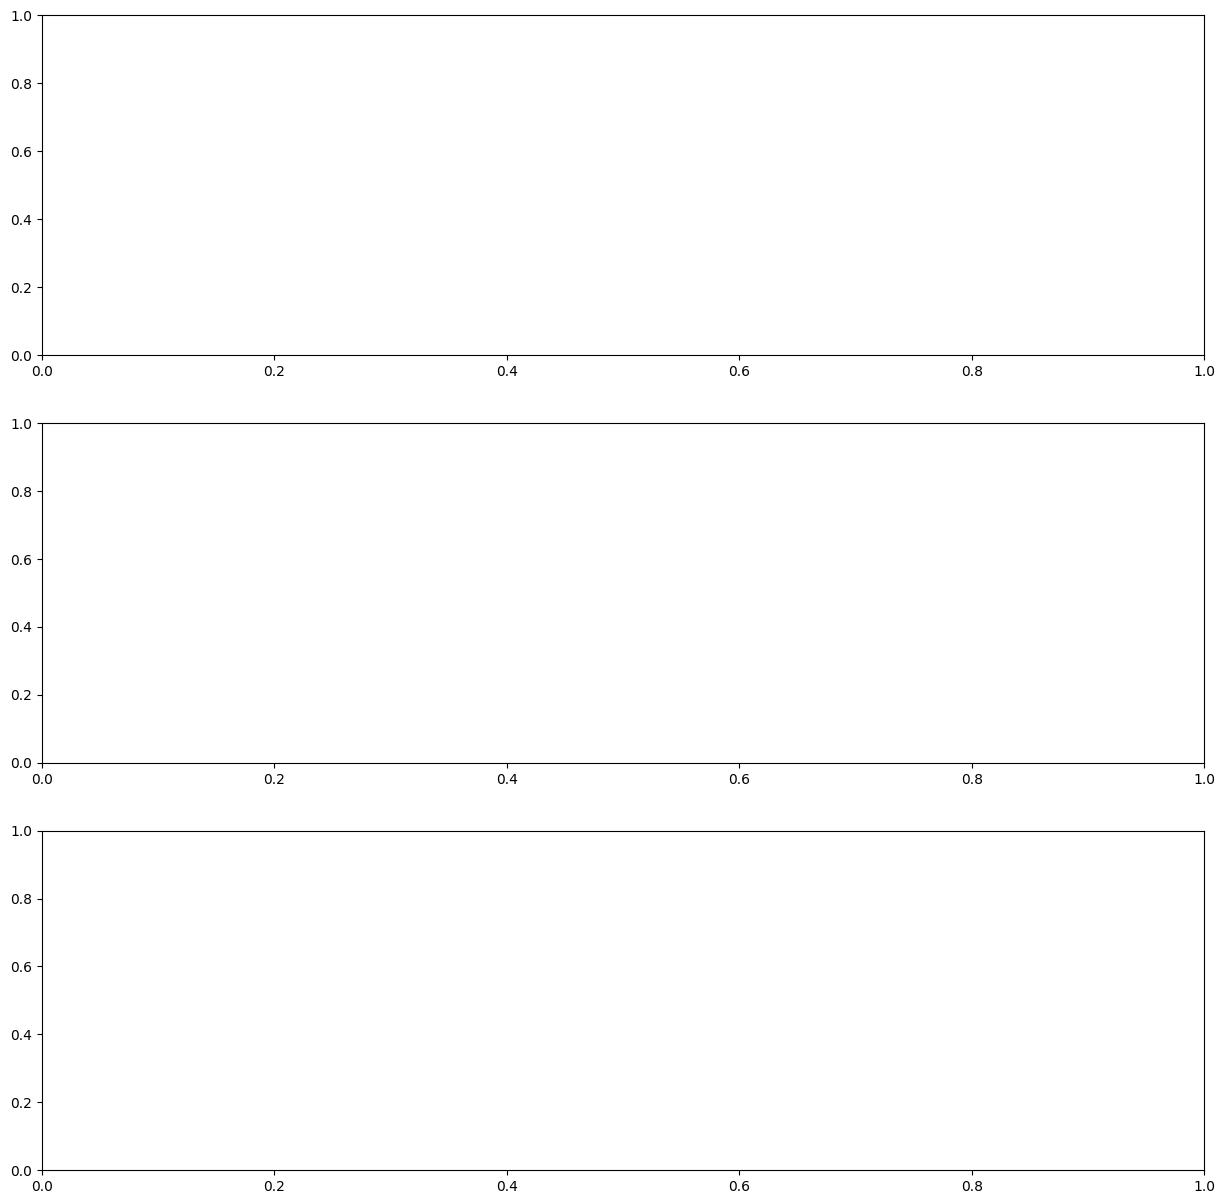

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
ind = 0
for i in range(3):
    column = crypto_values[ind]
    color = colors[ind]
    axs[i].plot(x=crypto_df.index, y=crypto_df[column], color=f'tab:{color}' )
    axs[i].set_title(column)
    ind += 1

for ax in axs.flat:
    ax.set(xlabel='Data', ylabel='Price')

for ax in axs.flat:
    ax.label_outer()

### Plotly

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=crypto_values)

ind = 0
for i in range(1,4):
    column = crypto_values[ind]
    color = colors[ind]
    fig.add_trace(go.Scatter(x=crypto_df.index, y=crypto_df[column], name=column), row=i, col=1)
    ind += 1

fig.show()

## Выводы

Графики выглядят похожими, предположительно есть связь между стоимостью этих величин.

# Посмотрим на изменение ежедневной доходности
(закрытие минус открытие в %)

In [ ]:
# matplotlib
# fig, axs = plt.subplots(3, 1, figsize=(15,15))
# ind = 0
# for i in range(3):
#     column = crypto_values[ind]
#     color = colors[ind]
#     axs[i].plot(crypto_df.index, crypto_df[column + '_val_chg'], f'tab:{color}' )
#     axs[i].set_title(column)
#     ind += 1

# for ax in axs.flat:
#     ax.set(xlabel='Data', ylabel='Price')

# for ax in axs.flat:
#     ax.label_outer()

# plotly
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=crypto_values)

ind = 0
for i in range(1,4):
    column = crypto_values[ind]
    color = colors[ind]
    fig.add_trace(go.Scatter(x=crypto_df.index, y=crypto_df[column + '_chg'], name=column), row=i, col=1)
    ind += 1

fig.show()

## Выводы
В течение большей части времени доходность составляет от -60% до 60% со скачками без пересечения отметки в 100% с обеих сторон, для bnb на старте заметен аномальный скачок, который будет искажать наши данные. Давайте удалим этот период из наших данных

In [ ]:
crypto_df = crypto_df.loc[pd.to_datetime('2018-05-01'):]

# Гистограмы распределения ежедневных доходов

array([[<Axes: title={'center': 'bitcoin_chg'}>,
        <Axes: title={'center': 'bnb_chg'}>],
       [<Axes: title={'center': 'ethereum_chg'}>, <Axes: >]], dtype=object)

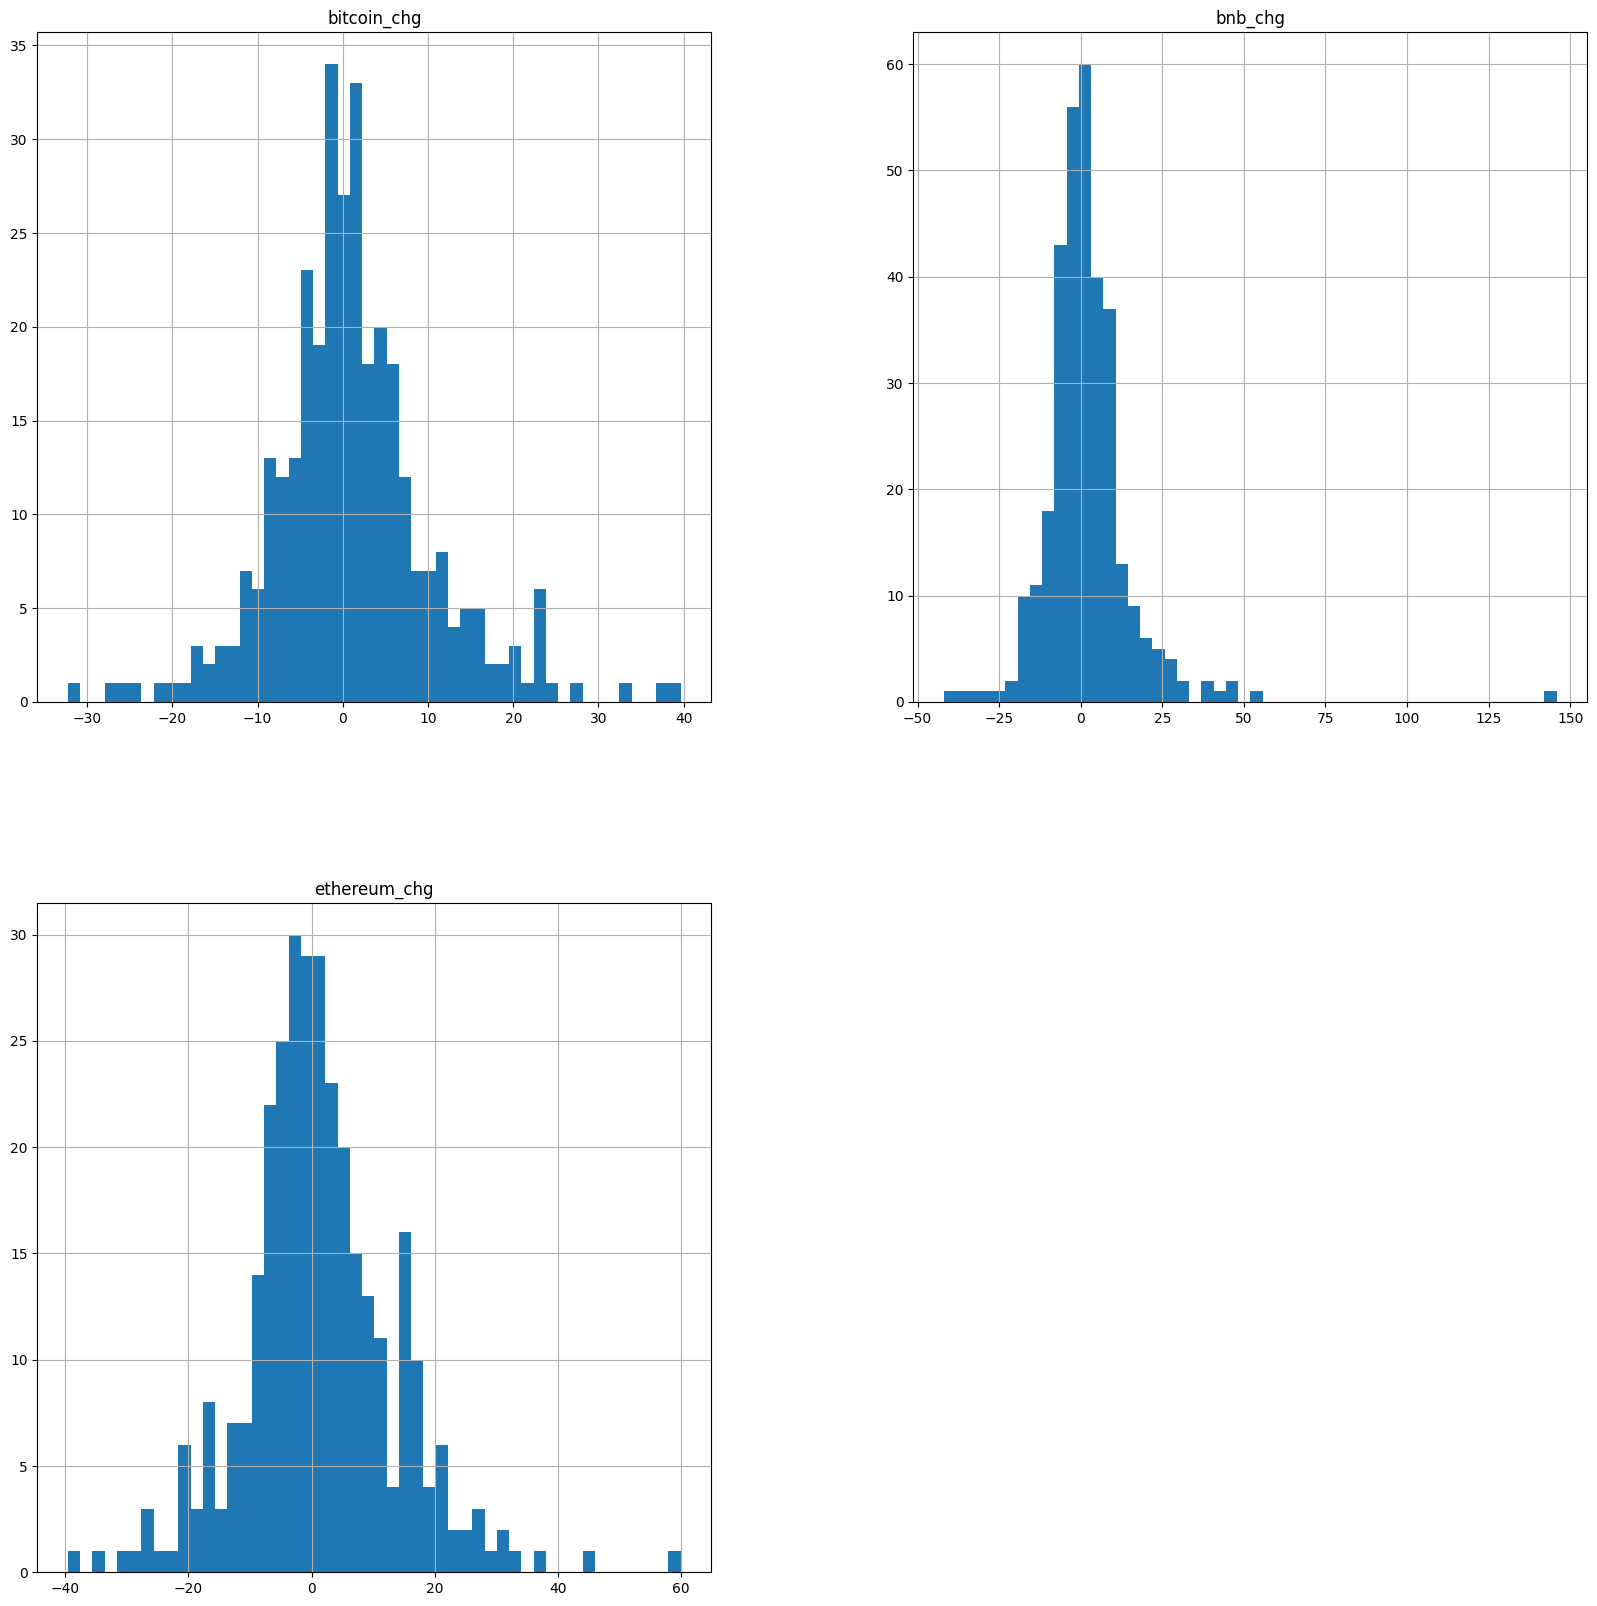

In [ ]:
crypto_df[[col + '_chg' for col in crypto_values]].hist(bins = 50, figsize=(20, 20))

# Вывод
Гистограммы ежедневных доходностей центрированы вокруг среднего значения и имеют нормально распределение.

Давайте проверим это тестом

In [ ]:
stat, p = stats.normaltest(crypto_df['ethereum_val_chg'])
print(f'stat={stat}, p={p}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=100.248224777992, p=1.7036272540804564e-22
Probably not Gaussian


Видим, что тест показывает крайне малое значение. Но если мы прологарифмируем, то получим уже более близкий к нормальному результат

In [ ]:
stat, p = stats.normaltest(np.log(crypto_df['ethereum_val_chg'] + 80))
print(f'stat={stat}, p={p}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=5.759275727640039, p=0.056155094943984685
Probably Gaussian


# Seaborn pairplot
Для более удобного сравнения есть метод pairplot

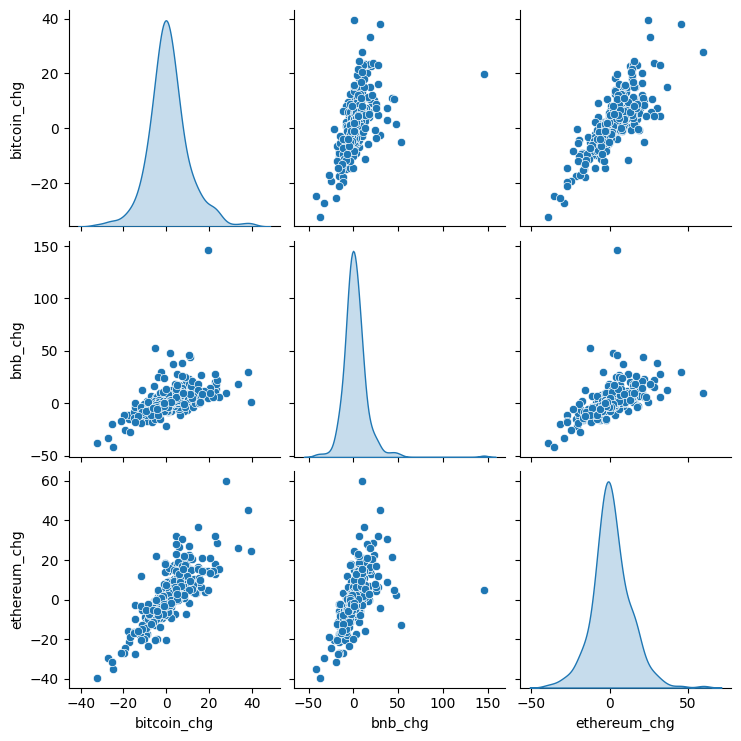

In [ ]:
seaborn.pairplot(crypto_df[[col + '_chg' for col in crypto_values]], diag_kind="kde")

In [ ]:
############### seaborn ##############
# создадим два подграфика
# f, (ax_box, ax_hist) = plt.subplots(nrows = 2, # из двух строк
#                                     ncols = 1, # и одного столбца
#                                     sharex = True, # оставим только нижние подписи к оси x
#                                     gridspec_kw = {'height_ratios': (.15, .85)}, # зададим разную высоту строк
#                                     figsize = (12,8)) # зададим размер графика


# # в первом подграфике построим boxplot
# seaborn.boxplot(x = crypto_df['bitcoin_val_chg'], ax = ax_box)
# # во втором гистограмму
# seaborn.histplot(data = crypto_df['bitcoin_val_chg'], bins = 15, ax = ax_hist)

# plt.show()



################ plotly##############
fig = px.histogram(crypto_df, x='bitcoin_chg',
                   marginal="violin", # or violin, rug)
                  )
fig.show()

## Преобразование бокса кокса
Данное преобразование позволяет уменьшить влияние выбросов

In [ ]:
# seaborn
# f, (ax_box, ax_hist) = plt.subplots(nrows = 2, # из двух строк
#                                     ncols = 1, # и одного столбца
#                                     sharex = True, # оставим только нижние подписи к оси x
#                                     gridspec_kw = {'height_ratios': (.15, .85)}, # зададим разную высоту строк
#                                     figsize = (12,8)) # зададим размер графика

# в первом подграфике построим boxplot
# box_changed = stats.boxcox(x=(crypto_df['bitcoin_val_chg'] - crypto_df['bitcoin_val_chg'].min() + 1))[0]
# seaborn.boxplot(x = box_changed, ax = ax_box)
# # во втором гистограмму
# seaborn.histplot(data = box_changed, bins = 15, ax = ax_hist)

# plt.show()

crypto_df['boxcox_bitcoin_chg'] = stats.boxcox(x=(crypto_df['bitcoin_chg'] - crypto_df['bitcoin_chg'].min() + 1))[0]

# plotly
fig = px.histogram(crypto_df, x='boxcox_bitcoin_chg',
                   marginal="violin", # or violin, rug)
                  )
fig.show()

# Корреляция
Так как наши распределения все же не нормальные, то будем использовать корреляцию Спирмана для получения информации о линейных связях

<Axes: >

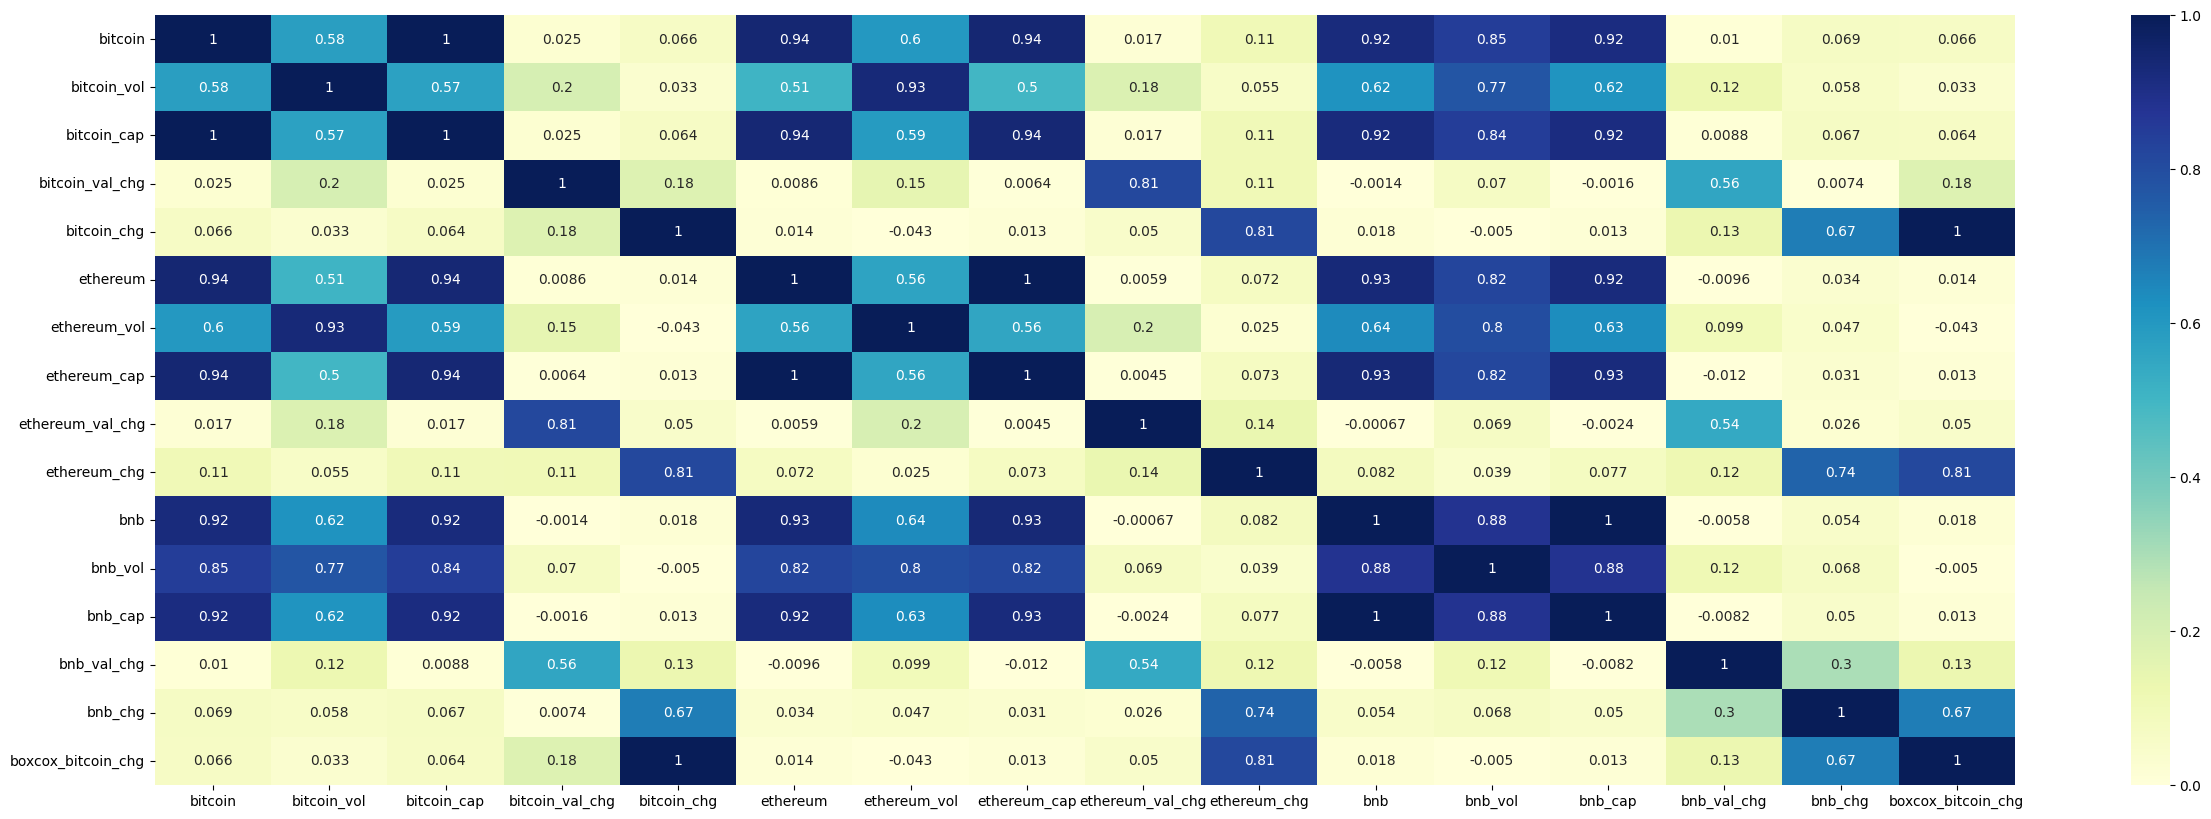

In [ ]:
plt.figure(figsize=(30,10))
seaborn.heatmap(crypto_df.corr(method='spearman', numeric_only=True), vmin=0, vmax=1, cmap='YlGnBu', annot=True)

# Вывод
Заметно, что изменение bitcoin очень сильно линейно влияет на изменение ethereum.

# Проанализируем тренды

Оценим как менялся тренд у криптовалют

In [48]:
trend_crypto = crypto_df[[col + '_chg' for col in crypto_values]]
def trend(x):
    if x > -5 and x <= 5:
        return 'Не менялся'
    elif x > 5 and x <= 15:
        return 'Небольшое увеличение'
    elif x > -15 and x <= -5:
        return 'Небольшой уменьшение'
    elif x > 15 and x <= 25:
        return 'увеличение'
    elif x > -25 and x <= -15:
        return 'уменьшение'
    elif x > 25 and x <= 50:
        return 'Значительное увеличение'
    elif x > -50 and x <= -25:
        return 'Значительное уменьшение'
    elif x > 50:
        return 'Максимальное увеличение'
    elif x <= -50:
        return 'Максимальное уменьшение'

for stock in trend_crypto.columns:
    trend_crypto["Trend_"+ str(stock)] = trend_crypto[stock].apply(lambda x:trend(x))

In [49]:
trend_columns = [col for col in trend_crypto.columns if 'Trend_' in col]
ind = 0

for i in range(3):
    column = trend_columns[ind]
    data_to_plot = trend_crypto[column].value_counts().round(3)
    fig = px.pie(values=data_to_plot, names=data_to_plot.index)
    fig.update_layout(title=column)
    fig.show()
    ind += 1

# Что еще можно посмотреть?

Text(0.5, 1.0, 'ethereom')

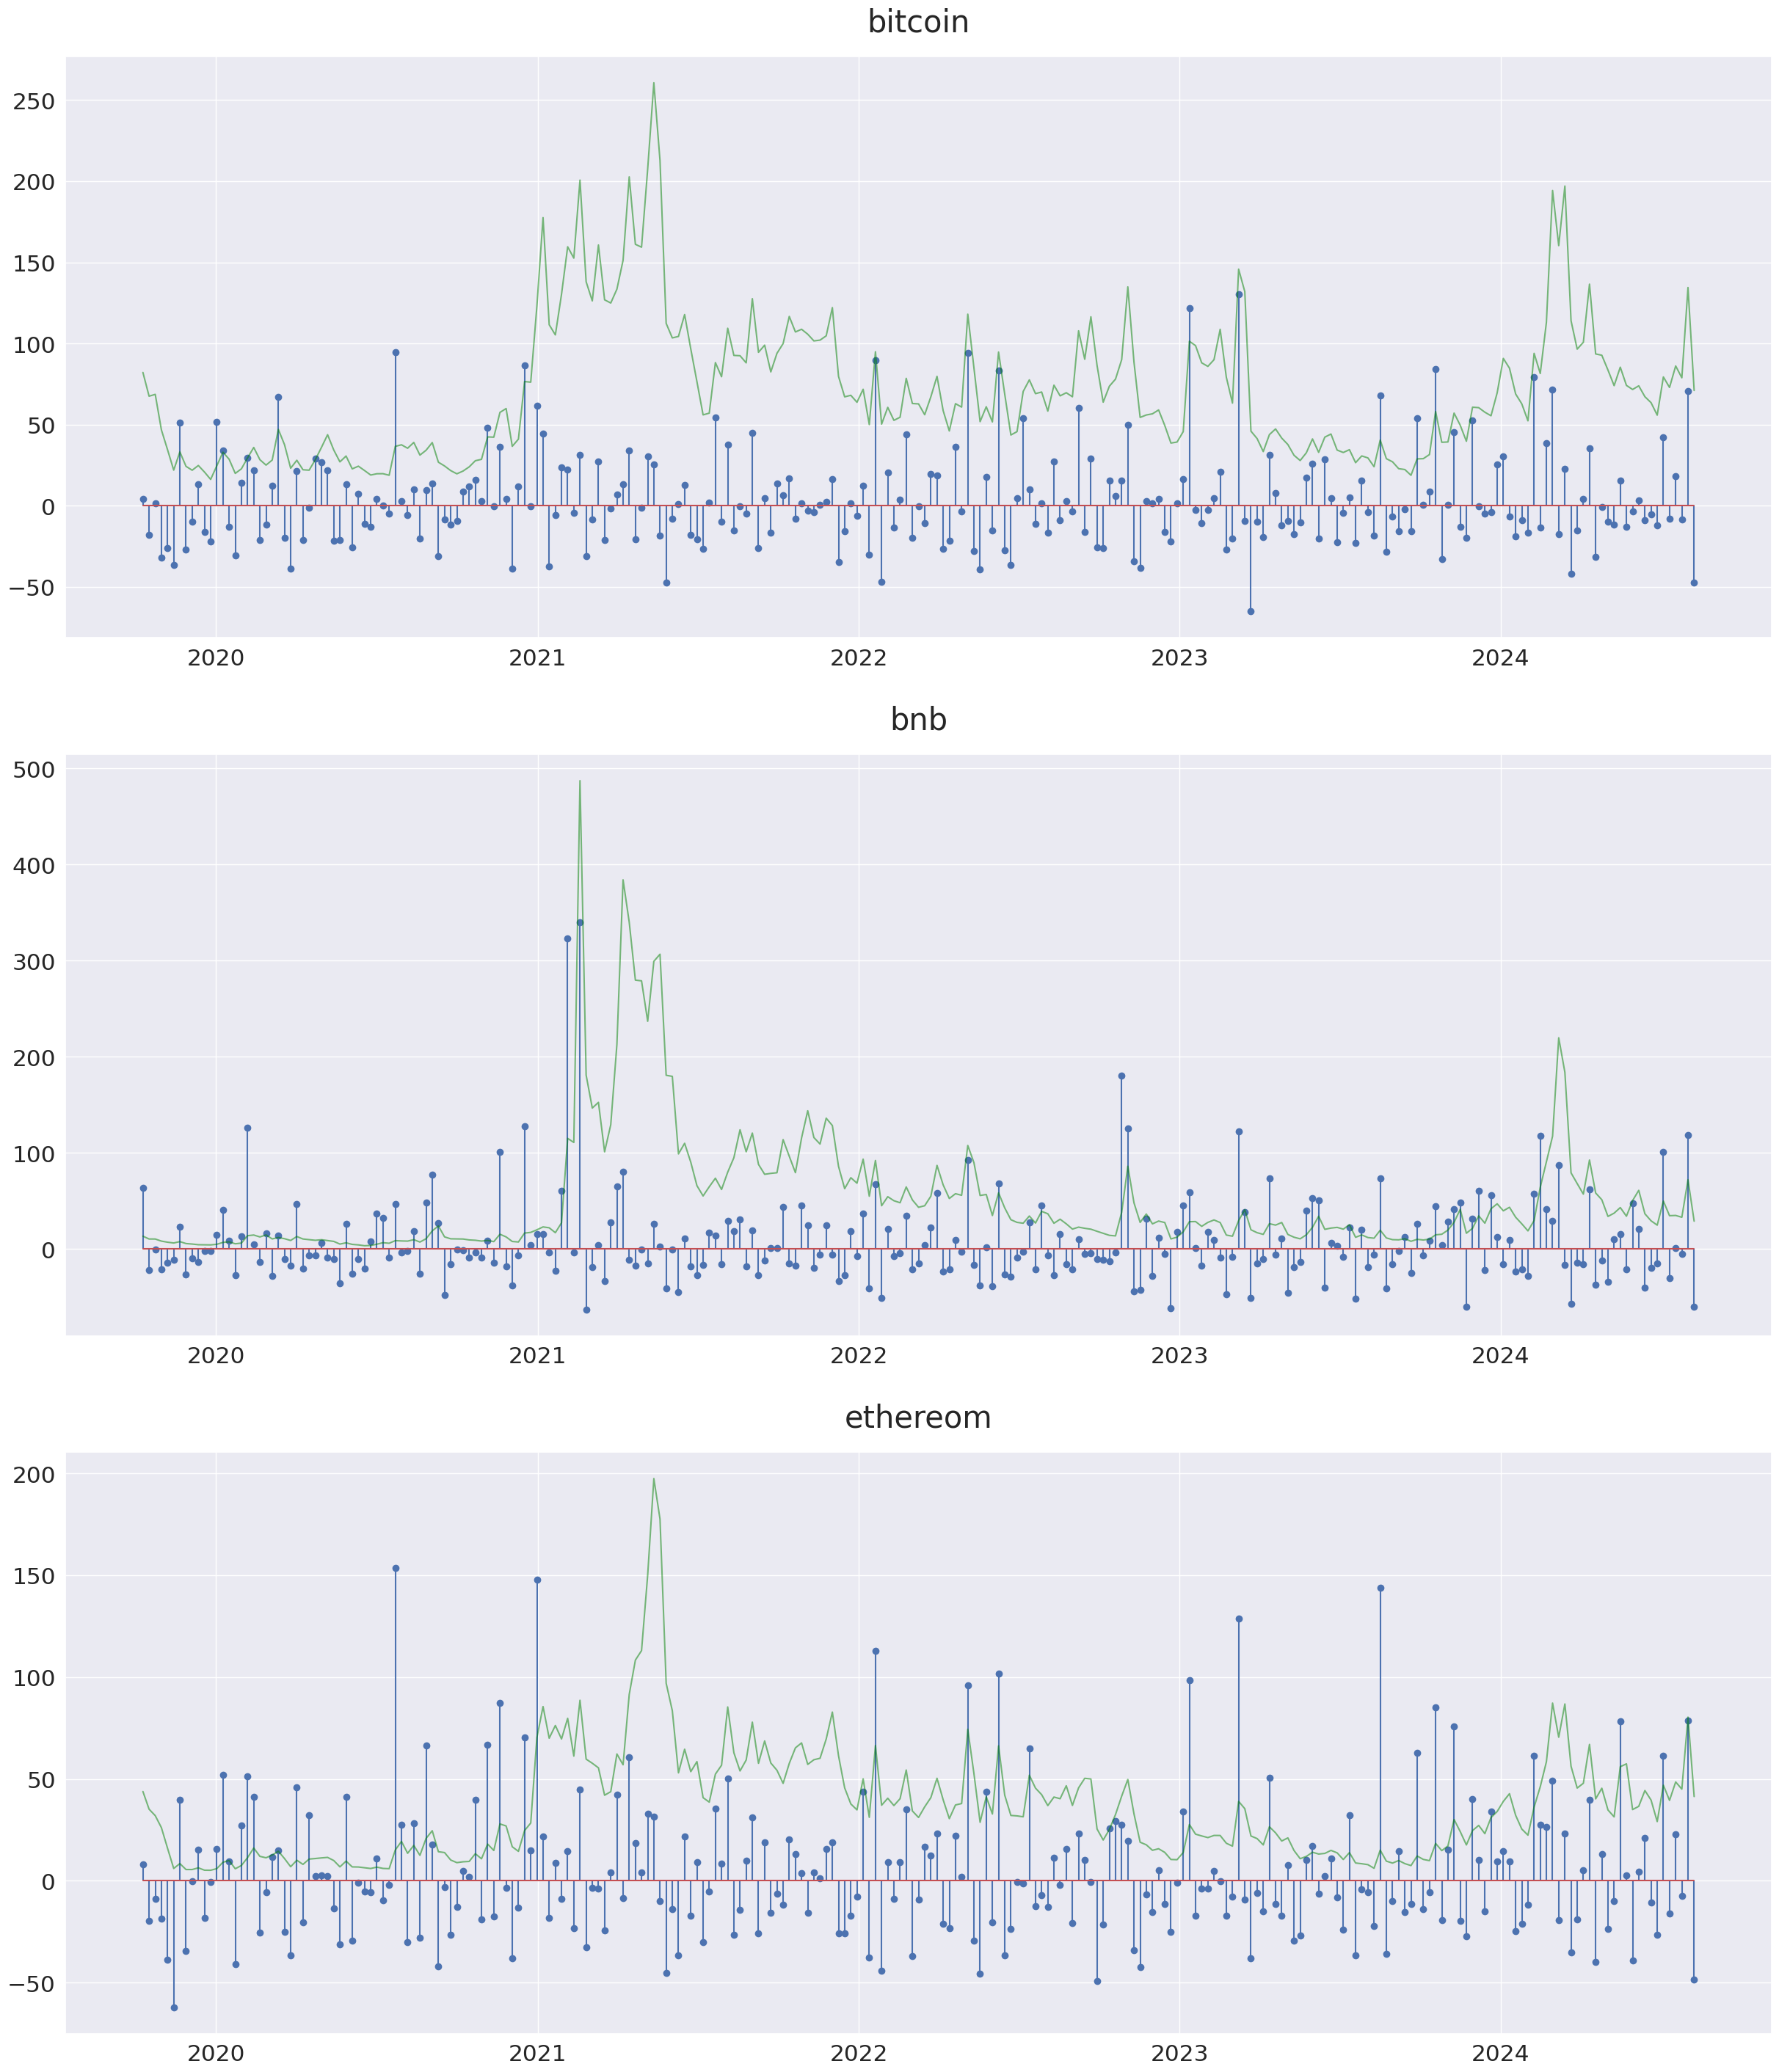

In [ ]:
seaborn.set(style="darkgrid")

size=30
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
fig, axs = plt.subplots(3, 1, figsize=(30,35))

axs[0].stem(crypto_df.index[-253:], crypto_df['bitcoin_val_chg'][-253:])
axs[0].plot((crypto_df['bitcoin_vol'] / 10**9)[-253:], color = 'green', alpha = 0.5)
axs[0].set_title('bitcoin')
# axs[0].set_fontsize(20)

axs[1].stem(crypto_df.index[-253:], crypto_df['bnb_val_chg'][-253:])
axs[1].plot((crypto_df['bnb_vol'] / 10**8 )[-253:], color = 'green', alpha = 0.5)
axs[1].set_title('bnb')
# axs[1].set_fontsize(20)

axs[2].stem(crypto_df.index[-253:], crypto_df['ethereum_val_chg'][-253:])
axs[2].plot((crypto_df['ethereum_vol'] / 10**9)[-253:], color = 'green', alpha = 0.5)
axs[2].set_title('ethereom')
# axs[2].set_fontsize(20)
# SMALL_SIZE = 16



# Разложение временного ряда по компонентам

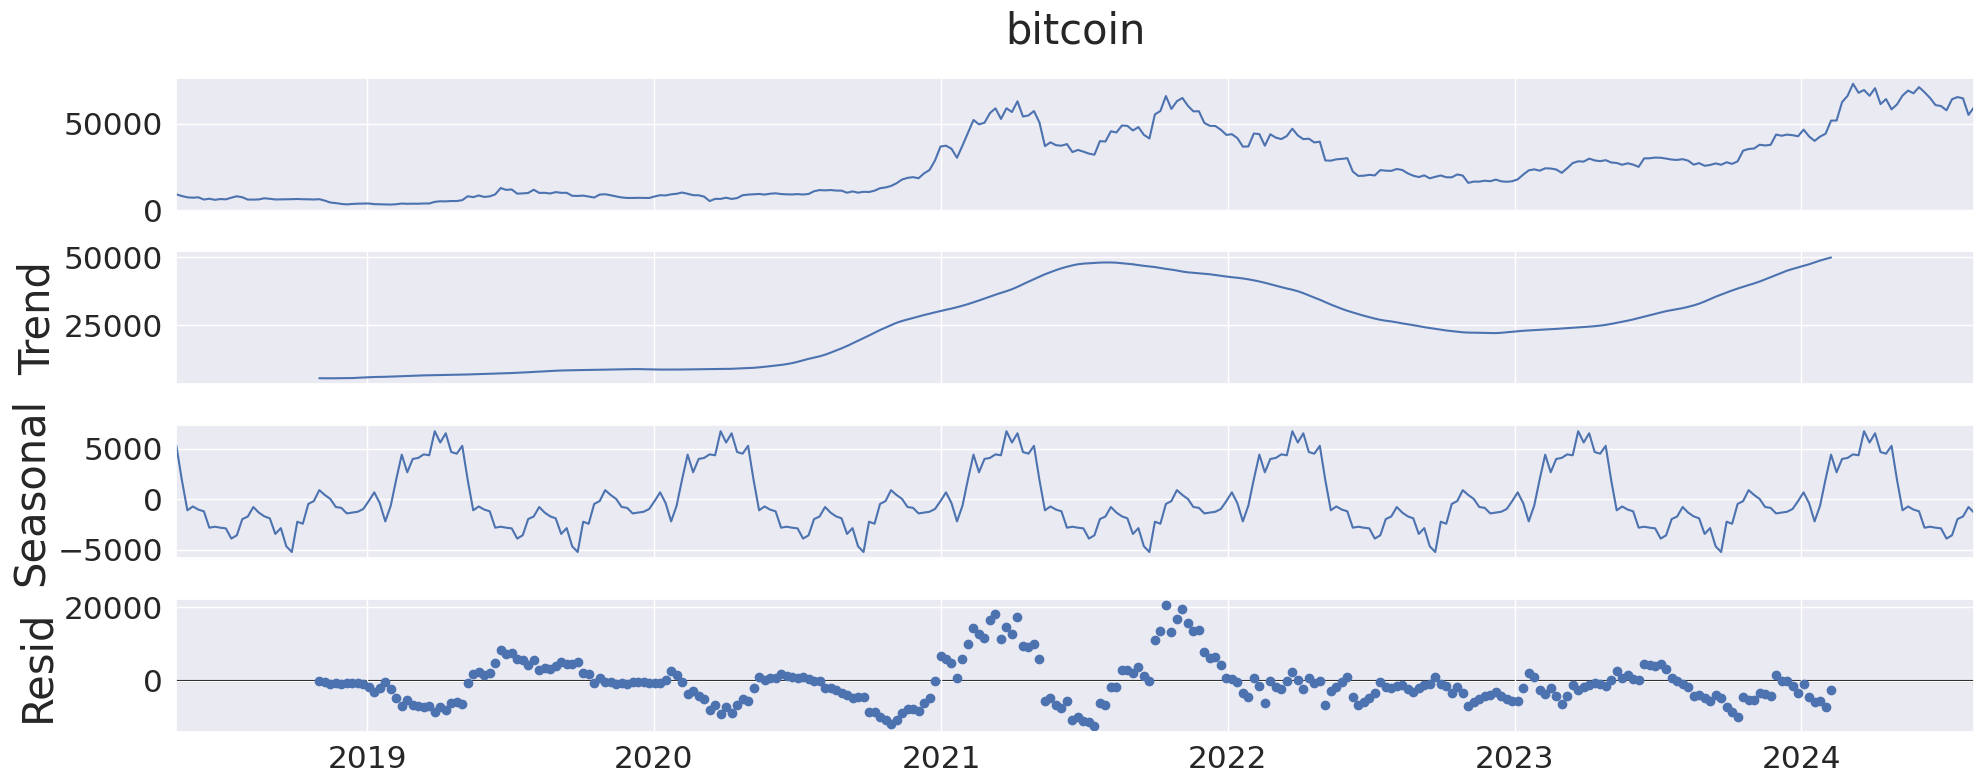

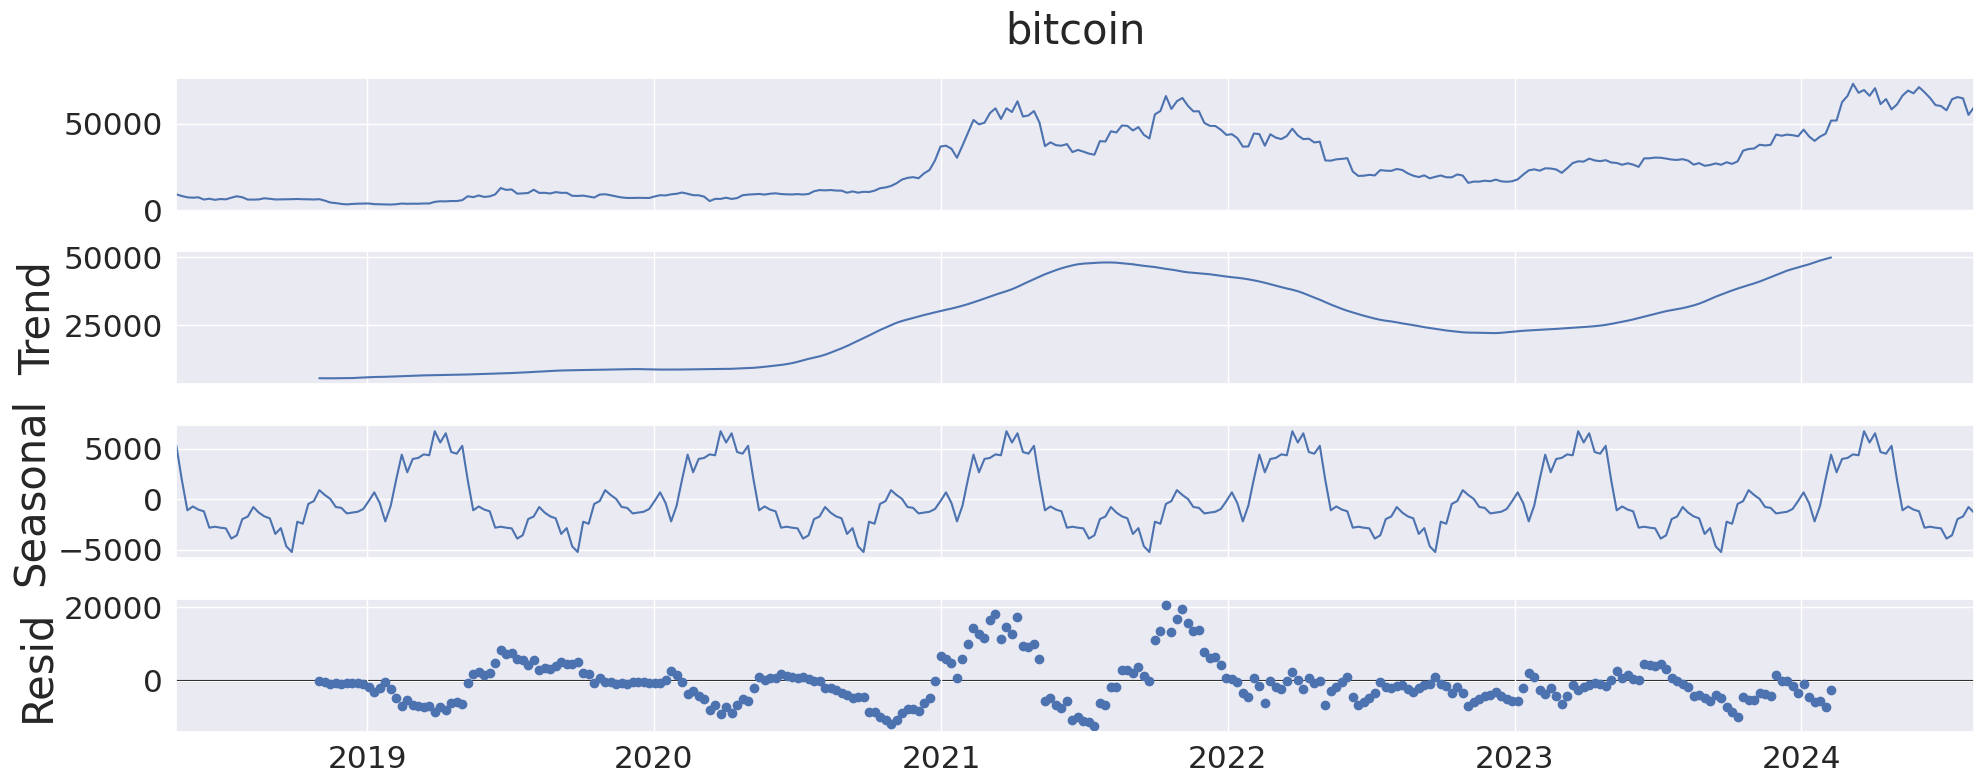

In [ ]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(crypto_df['bitcoin']).plot()